# ORF307: Homework 3

In [1]:
# Import required packages for coding exercises
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from numpy.linalg import cholesky as llt

## Q1: Robust Approximate Solution of Linear Equations (20 pts) {-}
The problem is listed above in the written portion.

## Q2: Least Norm Polynomial Interpolation (40 pts) {-}

(a) The problem is listed above in the written portion.

[-2.51167910e-16 -4.44089210e-16  1.83333333e+00  3.33333333e-01
 -1.16666667e+00]


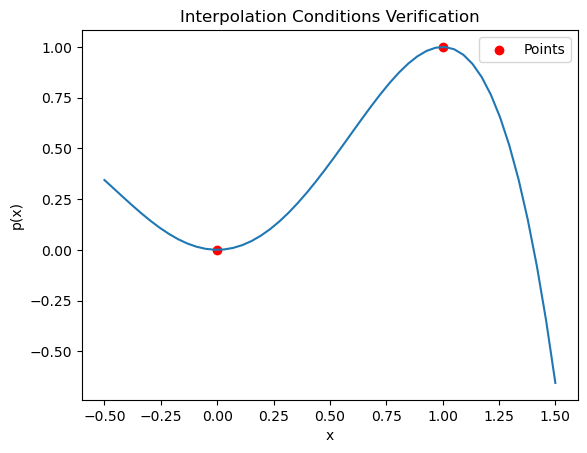

In [2]:
## Question 1 Part B

P = np.array([[1,0,0,0,0],[0,1,0,0,0],[1,1,1,1,1],[0,1,2,3,4]])
b = np.array([0,0,1,0]).T
c, *_ = np.linalg.lstsq(P, b)

print(c)

def p(x):
  return (11/6)*x**2 + (1/3)*x**3 + (-7/6)*x**4
x_vals = np.linspace(-0.5, 1.5)
y_vals = p(x_vals)
plt.plot(x_vals, y_vals)
plt.xlabel("x")
plt.ylabel("p(x)")
plt.title("Interpolation Conditions Verification")
plt.scatter([0, 1], [0, 1], color='red', label="Points")
plt.legend()

## Q3: Linear Quadratic Control (40 pts)

**State feedback control of the longitudinal motions of a Boeing 747 aircraft.** In this exercise we consider the control of the longitudinal motions of a Boeing 747 aircraft in steady level flight, at an altitude of 40000 ft, and speed 774 ft/s, which is 528 MPH or 460 knots, around Mach 0.8 at that altitude. Longitudinal means that we consider climb rate and speed, but not turning or rolling motions. For modest deviations from these steady state or trim conditions, the dynamics is given by the linear dynamical system $x_{t+1} = A x_t + B u_t$, with 
$$
A = \begin{bmatrix}
0.99 & 0.03 & -0.02 & -0.32 \\
0.01 & 0.47 & 4.70 & 0.00 \\
0.02 & -0.06 & 0.40 & 0.00 \\
0.01 & -0.04 & 0.72 & 0.99 \\
\end{bmatrix}
,\quad
B = \begin{bmatrix}
0.01 & 0.99 \\
-3.44 & 1.66 \\
-0.83 & 0.44 \\
-0.47 & 0.25 \\
\end{bmatrix}.
$$

In [3]:
import numpy as np
A = np.array([[.99, .03, -.02, -.32], 
              [.01, .47, 4.7, 0], 
              [.02, -.06, .4, 0], 
              [.01, -.04, .72, .99]])
B = np.array([[.01, .99], 
              [-3.44, 1.66], 
              [-.83, .44], 
              [-.47, .25]])

with time unit one second. The state $4$-vector $x_t$ consists of deviations from the trim conditions of the following quantities.  
- $(x_t)_1$ is the velocity along the airplane body axis, in ft/s, with forward motion
positive. 
- $(x_t)_2$ is the velocity perpendicular to the body axis, in ft/s, with positive down. 
- $(x_t)_3$ is the angle of the body axis above horizontal, in units of 0.01 radian. 
- $(x_t)_4$ is the derivative of the angle of the body axis, called the pitch rate, in units of 0.01 radian/s.


The input 2-vector ut (which we can control) consists of deviations from the trim conditions of the following quantities. 
- $(u_t)_1$ is the elevator (control surface) angle, in units of 0.01 radian.
- $(u_t)_2$ is the engine thrust, in units of 10000 lbs. You do not need to know these details; 

we mention them only so you know what the entries of $x_t$ and $u_t$ mean.


In [4]:
def KKT_matrix_rhs(A, b, C, d):
    """ 
    returns the KKT matrix and the right hand side vector that describes the 
    linear system to solve the constrained least squares problem
    """
    m, n = A.shape
    p, n = C.shape

    G = A.T @ A  # Gram matrix
    KKT = np.block([[2*G, C.T], 
                    [C, np.zeros((p, p))]])
    rhs = np.hstack([2*A.T @ b, d])
    return KKT, rhs

In [5]:
def construct_tilde_matrices(A, B, C, x_init, x_des, T, rho):
    """
    Construct A_tilde, b_tilde, c_tilde, d_tilde.
    """
    n, m = B.shape
    p = C.shape[0]

    A_tilde = np.block([[np.kron(np.eye(T), C), np.zeros((p * T, m * (T-1)))], 
                        [np.zeros((m * (T - 1), n * T)), np.sqrt(rho) * np.eye(m * (T-1))]])

    # construct btilde
    b_tilde = np.zeros(p * T + m * (T - 1))

    # construct Ctilde bit by bit 
    C_tilde11 = np.hstack([np.kron(np.eye(T-1),A), np.zeros((n*(T-1),n))]) \
        - np.hstack([np.zeros((n*(T-1),n)), np.eye(n*(T-1))])
    C_tilde12 = np.kron(np.eye(T-1), B)
    C_tilde21 = np.block([[np.eye(n), np.zeros((n,n*(T-1)))], 
                          [np.zeros((n,n*(T-1))), np.eye(n)]])
    C_tilde22 = np.zeros((2 * n, m * (T-1)))

    C_tilde = np.block([[C_tilde11, C_tilde12],
                        [C_tilde21, C_tilde22]])

    # construct dtilde
    d_tilde = np.hstack([np.zeros(n * (T - 1)), x_init, x_des])
    
    return A_tilde, b_tilde, C_tilde, d_tilde

(a) Open loop trajectory. Simulate the motion of the Boeing 747 with initial condition
$x_1 = e_4$, in open-loop (i.e., with $u_t = 0$). Plot the state variables over the time interval $t = 1, . . . , 120$ (two minutes). The oscillation you will see in the open-loop
simulation is well known to pilots, and called the phugoid mode. (20 pts)


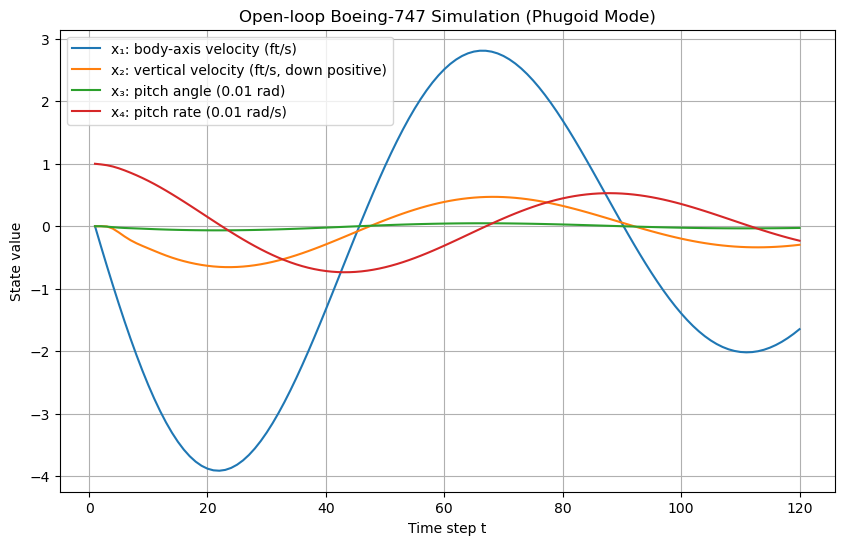

In [6]:
# Question 3 Part A

x_init = np.array([0, 0, 0, 1])

T = 120

# open-loop simulation
x = np.zeros((T,4))
x[0] = x_init
for t in range(T-1):
    x[t+1] = A @ x[t]   # u_t = 0 so B u_t drops out

# time axis (1..120)
k = np.arange(1, T+1)

# plot each state
labels = [
    "x₁: body-axis velocity (ft/s)",
    "x₂: vertical velocity (ft/s, down positive)",
    "x₃: pitch angle (0.01 rad)",
    "x₄: pitch rate (0.01 rad/s)"
]

plt.figure(figsize=(10,6))
for i in range(4):
    plt.plot(k, x[:,i], label=labels[i])
plt.xlabel('Time step t')
plt.ylabel('State value')
plt.title('Open-loop Boeing-747 Simulation (Phugoid Mode)')
plt.legend()
plt.grid(True)
plt.show()

(b) Linear quadratic control. Solve the linear quadratic control problem with $C = I$,
$ρ = 100$, and $T = 120$, with initial state $x_1 = e_4$, and desired terminal state $x^{des} = 0$. Plot the state and input variables over $t = 1, \dots , 120$. You may use the following functions. (20 pts)

In [7]:
# Question 3 Part B

n, m = B.shape
T = 120

state_labels = [
    "Body-axis velocity x1 [ft/s]",
    "Vertical velocity x2 [ft/s]",
    "Pitch angle x3 [0.01 rad]",
    "Pitch rate x4 [0.01 rad/s]"
]
input_labels = [
    "Elevator angle u1 [0.01 rad]",
    "Engine thrust u2 [10,000 lbs]"
]

time_x = np.arange(1, T+1)
time_u = np.arange(1, T)

plt.figure(figsize=(10,6))
for i in range(n):
    plt.plot(time_x, state_var[:, i], label=state_labels[i])
plt.xlabel("Time (s)")
plt.ylabel("State value")
plt.title("LQR State Trajectories")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

plt.figure(figsize=(10,4))
for j in range(m):
    plt.plot(time_u, input_var[:, j], label=input_labels[j])
plt.xlabel("Time (s)")
plt.ylabel("Input value")
plt.title("LQR Control Inputs")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

NameError: name 'state_var' is not defined

<Figure size 1000x600 with 0 Axes>